# <div style='padding:25px;background-color:maroon;color:white;border-radius:4px;font-size:100%;text-align: center'>Banking Data Analysis<br></div>

# <div style='padding:7px;background-color:Maroon;color:white;border-radius:2px;font-size:100%;text-align: center'>Regression Modeling<br></div>

## <span style="color:Aqua;">Importing libraries from Python</span>

In [42]:
import pandas as pd
pd.options.display.max_columns = 50
pd.set_option("display.precision", 4)
pd.set_option('display.float_format', '{:.4f}'.format)

import numpy as np
import os

import seaborn as sns
sns.set_theme(context='notebook', style='white', palette='dark', font='sans-serif', font_scale=1, color_codes=True, rc=None)
sns.set_style({'axes.facecolor': 'white','axes.edgecolor': 'white'})

import matplotlib.pyplot as plt
plt.rcParams.update({
    'text.color': 'black',  # Change font color
    'axes.labelcolor': 'black',  # Change axis label color
    'xtick.color': 'black',  # Change x-tick color
    'ytick.color': 'black',  # Change y-tick color
    'font.weight': 'bold',  # Change font weight
    'axes.titleweight': 'bold',  # Change title weight
    'axes.labelweight': 'bold',# Change label weight
})

import scipy.stats as stats
from scipy.stats import pearsonr,kstest, norm, skew,kurtosis, boxcox

from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler,MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score

from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import AdaBoostRegressor,GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, explained_variance_score,root_mean_squared_error,max_error
import xgboost as xg

import pickle
import time



In [2]:
def univar_num(df, col):
    plt.figure(figsize=(16, 8))
    df = df.dropna(subset=[col])


    mean=df[col].mean()
    median=df[col].median()
    mode=df[col].mode()[0]
    sns.set_style({'axes.facecolor': 'white','axes.edgecolor': 'white'})
    plt.subplot(2, 3, 1)
    sns.histplot(data=df, x=col, kde=True, bins=50,color='maroon',fill=True)
    plt.title(f'Histogram for {col}',fontdict={'fontsize':24,'color':'black','fontweight':'bold'})
    plt.axvline(mean, color='maroon', label='Mean',linewidth=2)
    plt.axvline(median, color='black', label='Median',linewidth=2)
    plt.axvline(mode, color='darkgreen', label='Mode',linewidth=2)
    sns.set_theme(context='notebook', style='white', palette='dark', font='sans-serif', font_scale=1, color_codes=True, rc=None)

    
    plt.legend()
    plt.tight_layout()
    
    plt.subplot(2, 3, 2)
    sns.boxplot(data=df, x=col, color='lightgrey',legend=True)
    plt.xticks(rotation=45)
    plt.title(f'Box Plot for {col}',fontdict={'fontsize':24,'color':'black','fontweight':'bold'})
    plt.axvline(mean, color='maroon', label='Mean',linewidth=2)
    plt.axvline(median, color='black', label='Median',linewidth=2)
    plt.axvline(mode, color='darkgreen', label='Mode',linewidth=2)
    plt.legend()
    plt.tight_layout()

    
    plt.subplot(2, 3, 3)
    stats.probplot(df[col], dist="norm", plot=plt)
    plt.gca().get_lines()[1].set_color('maroon')
    plt.gca().get_lines()[0].set_color('darkgreen')
    plt.title(f'QQ Plot for {col}',fontdict={'fontsize':24,'color':'black','fontweight':'bold'})

    plt.tight_layout()
    
    plt.tight_layout()
    plt.show()

In [3]:
def kurtosis_color(kurt_val):
    if -1 <= kurt_val <= 1:
        kurt_color = color_good  # Dark Green for near-zero kurtosis (good)
    elif 1 < kurt_val <= 3 or -3 <= kurt_val < -1:
        kurt_color = color_okay  # Yellow for moderate kurtosis
    else:  # kurt_val > 3 or kurt_val < -3
        kurt_color = color_bad  # Maroon for extreme kurtosis
    return kurt_color

def skewness_color(skew_val):
    if -0.5 <= skew_val <= 0.5:
        color = color_good  # Dark Green for near-zero skew
    elif 0 < skew_val <= 0.5 or -0.5 < skew_val < 0:
        color = color_okay  # Light Green for slightly positive or slightly negative skew
    else:  # skew_val > 0.5 or skew_val < -0.5
        color = color_bad  # Maroon for significant skew
    return color

In [4]:

# Defining a function to perform Box-Cox
def boxcox_transform(x):
    transformed_data,lmbda = boxcox(x + np.spacing(1))
    return transformed_data,lmbda

method_functions =  {
    'log': lambda x: np.log(x + np.spacing(1)),
    'square': np.sqrt,
    'rec': lambda x: np.where(x != 0, 1 / x, np.spacing(1)),
    'sig': lambda x: 1 / (1 + np.exp(-x)),
    'cube': lambda x: np.power(x, 3),
    'exp':lambda x: x**(1/5),
    'boxcox': boxcox_transform,
        }

def skewness_checker(df, column, method,pkl_path=None):
    transformed_columns = {}
    transformation_params = {}

    for method_name, func in method_functions.items():
        for col in column:

            new_column = f'{col}_{method_name}'
            if method_name == 'boxcox':
                transformed_values, lmbda = func(df[col])
                transformation_params[new_column] = lmbda 
            else:
                transformed_values = func(df[col])
            transformed_columns[new_column] = transformed_values
    normalized_df = pd.DataFrame(transformed_columns)
    if not os.path.exists(pkl_path):
        os.makedirs(pkl_path)
    file_path = os.path.join(pkl_path,'transformation_params.pkl')
    with open(file_path, 'wb') as f:
        pickle.dump(transformation_params, f)
        
    return normalized_df, transformation_params

## <span style="color:Aqua;">Reading model dataset:</span>

In [5]:
df = pd.read_feather('clustered.feather')
df1 = pd.read_csv('syntheticbank_data.xls',usecols=['Asset Growth','Revenue','Profitability'])
df_expanded = df1.sample(n=100000, replace=True, random_state=42).reset_index(drop=True)
print(df.info())
df.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 43 columns):
 #   Column                                     Non-Null Count   Dtype  
---  ------                                     --------------   -----  
 0   num_bank_accounts                          100000 non-null  int8   
 1   num_credit_card                            100000 non-null  int8   
 2   num_of_loan                                100000 non-null  int8   
 3   delay_from_due_date                        100000 non-null  int8   
 4   num_of_delayed_payment                     100000 non-null  int8   
 5   num_credit_inquiries                       100000 non-null  float64
 6   credit_mix                                 100000 non-null  int8   
 7   payment_of_min_amount                      100000 non-null  int8   
 8   credit_score                               100000 non-null  int8   
 9   credit_inquiry_per_loan                    100000 non-null  float64
 10  age_group

,num_bank_accounts,num_credit_card,num_of_loan,delay_from_due_date,num_of_delayed_payment,num_credit_inquiries,credit_mix,payment_of_min_amount,credit_score,credit_inquiry_per_loan,age_group,disposable_income,age_boxcox,annual_income_boxcox,monthly_inhand_salary_boxcox,interest_rate_boxcox,outstanding_debt_square,credit_utilization_ratio_log,credit_history_age_boxcox,changed_credit_limit_cube,total_emi_per_month_square,amount_invested_monthly_boxcox,monthly_balance_boxcox,credit_limit_change_rate_exp,debt_income_ratio_log,loan_income_ratio_month_boxcox,credit_utilization_per_account_boxcox,reliable_payment_boxcox,delayed_payment_ratio_boxcox,investment_to_income_ratio_square,total_credit_exposure_boxcox,credit_utilization_to_income_ratio_boxcox,savings_rate_rec,income_stability_boxcox,total_liability_boxcox,debt_paytime_log,High_Spent_Large_Value_Payments,High_Spent_Medium_Value_Payments,High_Spent_Small_Value_Payments,Low_Spent_Large_Value_Payments,Low_Spent_Medium_Value_Payments,Low_Spent_Small_Value_Payments,Cluster
81639,7,3,4,23,15,6.0000,1,0,1,2.0000,0,3146.6859,7.5176,13.7757,11.5945,4.9448,18.6456,3.4657,132.3814,125,9.1129,7.0823,22.1718,0.4630,8.4220,1.8771,0.8567,2.2734,1.3010,0.1107,17.0165,-9.3509,81.5629,0.0657,17.8272,1.4199,1,0,0,0,0,0,1
57821,3,5,4,6,15,13.0000,1,2,2,3.0000,1,1478.7688,9.2002,12.5412,10.2432,6.0230,25.2488,3.5264,64.6864,51,10.9891,6.3703,20.5475,0.6369,7.4515,1.5805,1.0566,3.5805,1.3010,0.1406,20.9138,-8.0009,50.5337,0.1146,21.8458,1.6555,0,0,0,1,0,0,1
62602,6,5,7,20,16,9.0000,1,2,1,2.0000,1,8619.4995,8.1014,15.7365,13.7534,6.9734,36.1613,3.5835,58.5713,49,22.2362,9.4923,24.9432,0.7103,9.0695,1.6620,0.9364,3.8955,0.7704,0.0913,26.6788,-11.1711,120.0487,-0.0265,29.7937,0.8791,1,0,0,0,0,0,1


In [6]:
print(df_expanded.info())
df_expanded.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   Asset Growth   100000 non-null  int64
 1   Revenue        100000 non-null  int64
 2   Profitability  100000 non-null  int64
dtypes: int64(3)
memory usage: 2.3 MB
None


,Asset Growth,Revenue,Profitability
73869,62,189,25
52124,95,780,33
85355,34,632,10


In [7]:
df_expanded.isnull().sum()

Asset Growth     0
Revenue          0
Profitability    0
dtype: int64

In [8]:
df_expanded.describe()

,Asset Growth,Revenue,Profitability
count,100000.0000,100000.0000,100000.0000
mean,50.4499,500.8944,24.5835
std,28.9958,288.1877,14.8450
min,0.0000,1.0000,0.0000
25%,26.0000,262.0000,12.0000
50%,50.0000,503.0000,24.0000
75%,75.0000,748.0000,38.0000
max,100.0000,1000.0000,50.0000


In [9]:
df_new = pd.concat([df,df_expanded],axis=1)

In [10]:
df_new.columns = df_new.columns.str.replace(' ', '_').str.lower()
df_new.sample(3)

,num_bank_accounts,num_credit_card,num_of_loan,delay_from_due_date,num_of_delayed_payment,num_credit_inquiries,credit_mix,payment_of_min_amount,credit_score,credit_inquiry_per_loan,age_group,disposable_income,age_boxcox,annual_income_boxcox,monthly_inhand_salary_boxcox,interest_rate_boxcox,outstanding_debt_square,credit_utilization_ratio_log,credit_history_age_boxcox,changed_credit_limit_cube,total_emi_per_month_square,amount_invested_monthly_boxcox,monthly_balance_boxcox,credit_limit_change_rate_exp,debt_income_ratio_log,loan_income_ratio_month_boxcox,credit_utilization_per_account_boxcox,reliable_payment_boxcox,delayed_payment_ratio_boxcox,investment_to_income_ratio_square,total_credit_exposure_boxcox,credit_utilization_to_income_ratio_boxcox,savings_rate_rec,income_stability_boxcox,total_liability_boxcox,debt_paytime_log,high_spent_large_value_payments,high_spent_medium_value_payments,high_spent_small_value_payments,low_spent_large_value_payments,low_spent_medium_value_payments,low_spent_small_value_payments,cluster,asset_growth,revenue,profitability
44582,3,4,4,30,12,9.0000,2,0,0,2.0000,4,3441.3578,15.4022,14.1297,11.7760,2.0035,30.8828,3.5835,109.6903,-64,9.8450,6.9196,16.1356,0.5756,8.5135,1.8634,1.0676,2.2592,1.0010,0.1032,23.9855,-9.5091,93.9138,-0.0530,24.5028,2.2762,0,0,0,0,0,1,1,1,878,47
3449,9,7,6,55,15,9.0000,0,2,1,2.0000,1,6396.9717,8.1014,15.1620,13.0912,6.5114,51.2691,3.3322,83.1043,-104,17.9289,8.6240,19.1752,0.6916,8.6700,1.7243,0.7139,3.0991,0.8562,0.0954,33.6827,-11.0333,109.7721,-0.0115,34.9141,2.0982,0,0,0,1,0,0,0,89,490,13
89727,2,1,1,15,1,9.0000,2,1,2,5.0000,1,6924.5307,8.1014,15.1999,13.1713,2.9057,30.7210,3.5835,151.1061,51,7.3179,8.6337,28.3044,0.5261,10.2321,2.0845,1.1161,-0.9023,-0.6259,0.0938,23.9006,-10.6114,113.7216,0.0048,24.0602,2.8508,0,1,0,0,0,0,1,5,983,18


In [11]:
continuous_columns = [
      'disposable_income', 'age_boxcox', 
    'annual_income_boxcox', 'monthly_inhand_salary_boxcox', 'interest_rate_boxcox', 
    'outstanding_debt_square', 'credit_utilization_ratio_log', 'credit_history_age_boxcox', 
    'total_emi_per_month_square', 'amount_invested_monthly_boxcox', 'monthly_balance_boxcox', 
    'credit_limit_change_rate_exp', 'debt_income_ratio_log', 'loan_income_ratio_month_boxcox', 
    'credit_utilization_per_account_boxcox', 'reliable_payment_boxcox', 'delayed_payment_ratio_boxcox', 
    'investment_to_income_ratio_square', 'total_credit_exposure_boxcox', 
    'credit_utilization_to_income_ratio_boxcox', 'savings_rate_rec', 'income_stability_boxcox', 
    'total_liability_boxcox', 'debt_paytime_log','changed_credit_limit_cube',
]

Ordinal_columns = [
    'num_bank_accounts', 'num_credit_card', 'num_of_loan', 'delay_from_due_date', 'num_credit_inquiries',
    'num_of_delayed_payment', 'credit_mix', 'payment_of_min_amount', 
      'age_group', 'cluster' ,'credit_inquiry_per_loan','high_spent_large_value_payments', 'high_spent_medium_value_payments',
       'high_spent_small_value_payments', 'low_spent_large_value_payments',
       'low_spent_medium_value_payments', 'low_spent_small_value_payments','credit_score'
]

print(len(continuous_columns) + len(Ordinal_columns))

43


In [12]:
for i in df_new.columns[-3:]:
    print(df_new[i].min(),'---',df_new[i].max())
    df_new[i] = pd.to_numeric(df_new[i],errors='raise',downcast='integer')

0 --- 100
1 --- 1000
0 --- 50


In [13]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 46 columns):
 #   Column                                     Non-Null Count   Dtype  
---  ------                                     --------------   -----  
 0   num_bank_accounts                          100000 non-null  int8   
 1   num_credit_card                            100000 non-null  int8   
 2   num_of_loan                                100000 non-null  int8   
 3   delay_from_due_date                        100000 non-null  int8   
 4   num_of_delayed_payment                     100000 non-null  int8   
 5   num_credit_inquiries                       100000 non-null  float64
 6   credit_mix                                 100000 non-null  int8   
 7   payment_of_min_amount                      100000 non-null  int8   
 8   credit_score                               100000 non-null  int8   
 9   credit_inquiry_per_loan                    100000 non-null  float64
 10  age_group

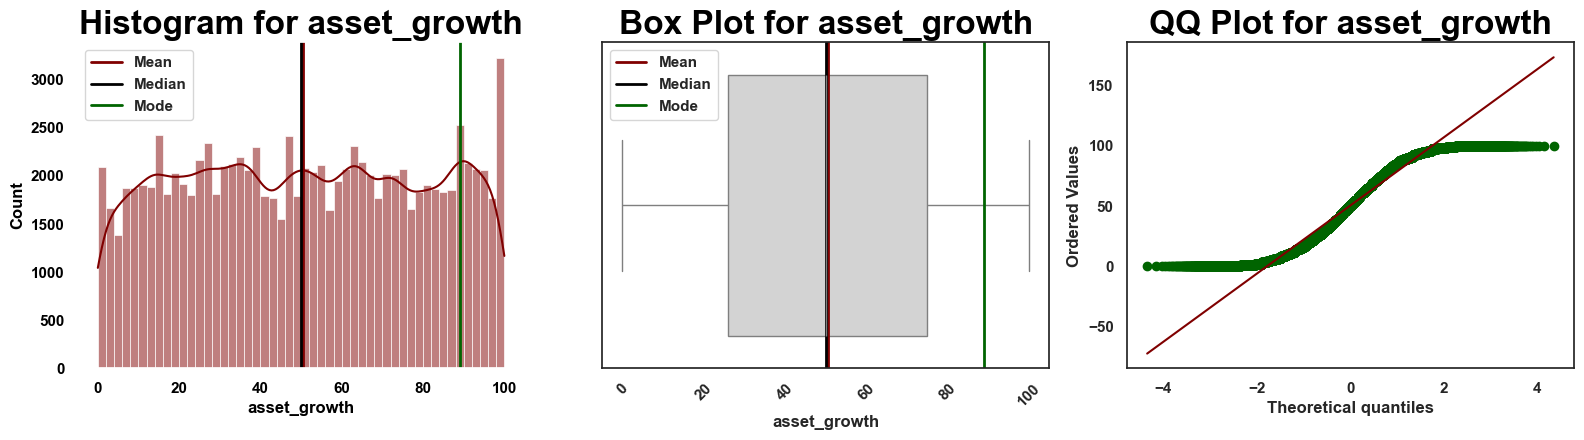



Skew for asset_growth is 0.0042
Kurtosis for asset_growth is -1.1901




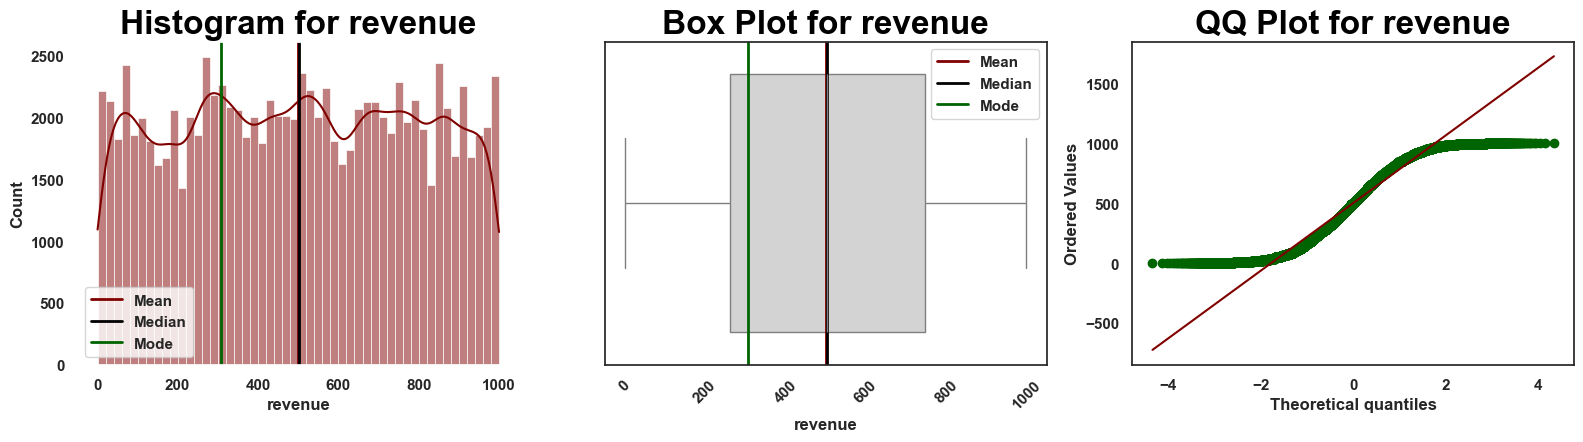



Skew for revenue is -0.0069
Kurtosis for revenue is -1.1759




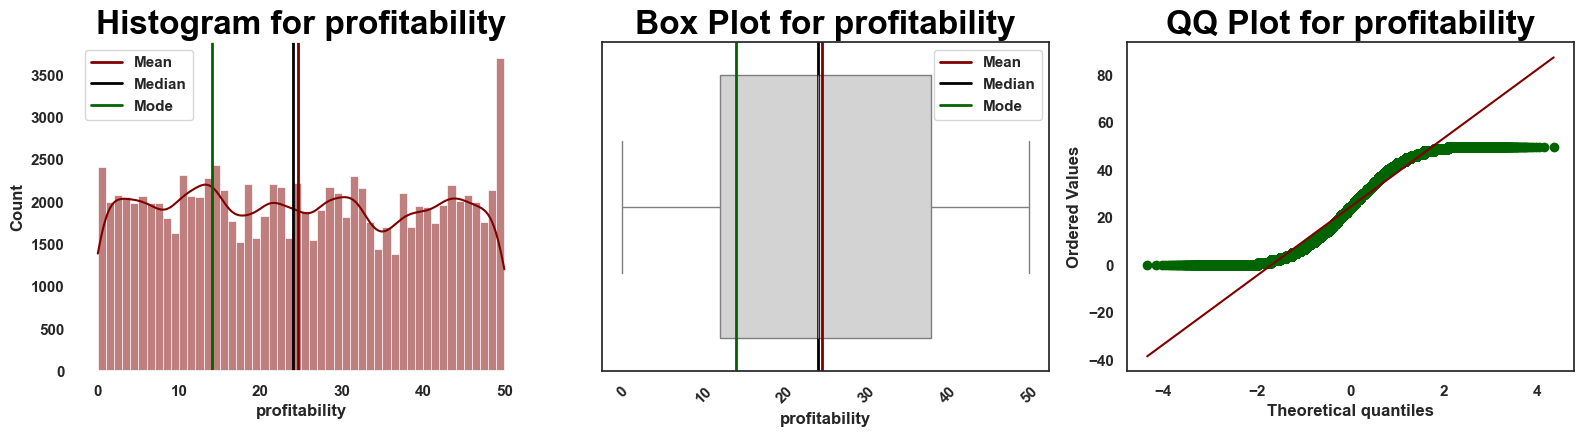



Skew for profitability is 0.0382
Kurtosis for profitability is -1.2136




In [14]:

color_good = '\033[32m'   # Dark Green for near-zero skew
color_okay = '\033[92m'   # Light Green for slightly positive or slightly negative skew
color_bad = '\033[91m'    # Maroon for significant skew
color_neutral = '\033[0m' # Reset color

for i in df_new.columns[-3:]:
    univar_num(df_new,i) 
    skew_val = df_new[i].skew()
    kurt=df_new[i].kurtosis()
    kurt_color = kurtosis_color(kurt)
    color = skewness_color(skew_val)

    print(f"\n\n{color}Skew for {i} is {skew_val:.4f}{color_neutral}")
    print(f"{color}Kurtosis for {i} is {kurt:.4f}{color_neutral}\n\n")

## <span style="color:Aqua;">Preparing the data afor modeling:</span>

In [15]:
df_new.drop_duplicates()
df_new=df_new.head(50000)
x = df_new.drop(df_new.columns[-3:],axis=1)
y = df_new[df_new.columns[-3:]]

In [16]:
x.describe().T

,count,mean,std,min,25%,50%,75%,max
num_bank_accounts,50000.0000,5.3465,2.6025,0.0000,3.0000,5.0000,7.0000,10.0000
num_credit_card,50000.0000,5.5374,2.0606,0.0000,4.0000,5.0000,7.0000,11.0000
num_of_loan,50000.0000,3.5459,2.4366,0.0000,2.0000,3.0000,5.0000,9.0000
delay_from_due_date,50000.0000,21.1640,14.7892,0.0000,10.0000,18.0000,28.0000,62.0000
num_of_delayed_payment,50000.0000,13.3087,6.2622,0.0000,9.0000,14.0000,18.0000,25.0000
num_credit_inquiries,50000.0000,5.8030,3.8861,0.0000,3.0000,5.0000,9.0000,17.0000
credit_mix,50000.0000,1.0690,0.7362,0.0000,1.0000,1.0000,2.0000,2.0000
payment_of_min_amount,50000.0000,1.1701,0.9225,0.0000,0.0000,2.0000,2.0000,2.0000
credit_score,50000.0000,0.8834,0.6769,0.0000,0.0000,1.0000,1.0000,2.0000
credit_inquiry_per_loan,50000.0000,1.8325,1.2861,0.0000,1.0000,2.0000,2.0000,11.0000


In [17]:
y.describe()

,asset_growth,revenue,profitability
count,50000.0000,50000.0000,50000.0000
mean,50.5563,502.0462,24.6298
std,29.0460,288.2282,14.8260
min,0.0000,1.0000,0.0000
25%,26.0000,263.0000,12.0000
50%,51.0000,504.0000,24.0000
75%,75.0000,749.0000,38.0000
max,100.0000,1000.0000,50.0000


In [18]:
y.value_counts()

asset_growth  revenue  profitability
35            857      7                32
85            852      11               31
31            271      21               31
63            141      12               30
10            143      14               30
                                        ..
31            858      42                6
59            401      32                6
97            838      36                6
80            280      38                5
57            443      29                5
Name: count, Length: 3000, dtype: int64

In [54]:
all_features = ['num_bank_accounts', 'num_credit_card', 'num_of_loan', 'delay_from_due_date',
    'num_of_delayed_payment', 'num_credit_inquiries', 'credit_mix','payment_of_min_amount', 
    'reliable_payment_boxcox', 'delayed_payment_ratio_boxcox','total_credit_exposure_boxcox',
    'credit_utilization_to_income_ratio_boxcox', 'savings_rate_rec','debt_paytime_log','interest_rate_boxcox',
    'age_boxcox','total_emi_per_month_square','amount_invested_monthly_boxcox','annual_income_boxcox',
             'income_stability_boxcox','total_liability_boxcox','investment_to_income_ratio_square',
             'outstanding_debt_square','credit_inquiry_per_loan','changed_credit_limit_cube''credit_score']

revised_features = ['num_bank_accounts','num_credit_card','num_of_loan','num_of_delayed_payment', 'delay_from_due_date',
                    'num_credit_inquiries', 'credit_mix','payment_of_min_amount',
                    'age_boxcox','total_emi_per_month_square','amount_invested_monthly_boxcox',
                    'annual_income_boxcox','total_liability_boxcox','outstanding_debt_square',
                    'savings_rate_rec','credit_score']

imp_fea = ['credit_mix','outstanding_debt_square','credit_utilization_ratio_log','interest_rate_boxcox','payment_of_min_amount',
    'total_liability_boxcox','num_credit_card','num_bank_accounts','total_credit_exposure_boxcox',
    'num_credit_inquiries','num_of_delayed_payment','delay_from_due_date','credit_limit_change_rate_exp',
    'loan_income_ratio_month_boxcox','disposable_income','annual_income_boxcox','total_emi_per_month_square',
    'monthly_inhand_salary_boxcox','debt_income_ratio_log','amount_invested_monthly_boxcox','savings_rate_rec',
    'income_stability_boxcox','age_boxcox','changed_credit_limit_cube','credit_score']

new = ['annual_income_boxcox','monthly_inhand_salary_boxcox','num_bank_accounts','num_credit_card','interest_rate_boxcox',
           'num_of_loan','credit_mix','outstanding_debt_square','credit_history_age_boxcox','total_liability_boxcox','credit_history_age_boxcox','credit_score'
           
        ]


## <span style="color:Aqua;">Splitting data for train_test and resampling imbalanced data classess:</span>

In [20]:
x_train, x_test,y_train, y_test = train_test_split(x,y,test_size=.3,random_state=42)

In [21]:
print(x_train.shape,'----', y_train.shape)
print(x_test.shape,'----', y_test.shape)

(35000, 43) ---- (35000, 3)
(15000, 43) ---- (15000, 3)


In [22]:
x_test.sample(2)

,num_bank_accounts,num_credit_card,num_of_loan,delay_from_due_date,num_of_delayed_payment,num_credit_inquiries,credit_mix,payment_of_min_amount,credit_score,credit_inquiry_per_loan,age_group,disposable_income,age_boxcox,annual_income_boxcox,monthly_inhand_salary_boxcox,interest_rate_boxcox,outstanding_debt_square,credit_utilization_ratio_log,credit_history_age_boxcox,changed_credit_limit_cube,total_emi_per_month_square,amount_invested_monthly_boxcox,monthly_balance_boxcox,credit_limit_change_rate_exp,debt_income_ratio_log,loan_income_ratio_month_boxcox,credit_utilization_per_account_boxcox,reliable_payment_boxcox,delayed_payment_ratio_boxcox,investment_to_income_ratio_square,total_credit_exposure_boxcox,credit_utilization_to_income_ratio_boxcox,savings_rate_rec,income_stability_boxcox,total_liability_boxcox,debt_paytime_log,high_spent_large_value_payments,high_spent_medium_value_payments,high_spent_small_value_payments,low_spent_large_value_payments,low_spent_medium_value_payments,low_spent_small_value_payments,cluster
34463,6,6,2,15,10,7.0000,1,1,2,3.0000,2,5546.4639,9.9746,14.9059,12.7184,5.5031,13.8463,3.6109,101.4618,-107,8.6613,9.6762,26.4317,0.5952,8.9650,2.0027,0.9442,2.1221,1.4497,0.1191,14.0839,-10.2574,70.4382,-0.0421,14.9308,0.9251,0,1,0,0,0,0,1
1377,8,5,1,14,9,8.0000,1,2,1,4.0000,1,7052.9620,8.6613,15.2657,13.2074,5.2293,21.3359,3.3673,180.4880,47,6.7279,10.1585,28.9345,0.5376,9.4223,2.1077,0.7748,1.1059,1.9001,0.1123,18.5956,-11.0779,79.3263,-0.0155,18.8266,2.2864,0,1,0,0,0,0,1


In [23]:
y_test.sample(2)

,asset_growth,revenue,profitability
49290,50,271,36
22281,69,526,49


## <span style="color:Aqua;">Normalizing / Scaling the data:</span>

In [24]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train[continuous_columns])
x_test_scaled = scaler.transform(x_test[continuous_columns])

In [25]:
x_train_scaled_continuous = pd.DataFrame(x_train_scaled, columns=continuous_columns)
x_test_scaled_continuous = pd.DataFrame(x_test_scaled, columns=continuous_columns)

In [26]:
x_train_scaled_df = pd.concat([x_train_scaled_continuous.reset_index(drop=True), x_train[Ordinal_columns].reset_index(drop=True)], axis=1)
x_test_scaled_df = pd.concat([x_test_scaled_continuous.reset_index(drop=True), x_test[Ordinal_columns].reset_index(drop=True)], axis=1)

In [27]:
x_train_scaled_df

,disposable_income,age_boxcox,annual_income_boxcox,monthly_inhand_salary_boxcox,interest_rate_boxcox,outstanding_debt_square,credit_utilization_ratio_log,credit_history_age_boxcox,total_emi_per_month_square,amount_invested_monthly_boxcox,monthly_balance_boxcox,credit_limit_change_rate_exp,debt_income_ratio_log,loan_income_ratio_month_boxcox,credit_utilization_per_account_boxcox,reliable_payment_boxcox,delayed_payment_ratio_boxcox,investment_to_income_ratio_square,total_credit_exposure_boxcox,credit_utilization_to_income_ratio_boxcox,savings_rate_rec,income_stability_boxcox,total_liability_boxcox,debt_paytime_log,changed_credit_limit_cube,num_bank_accounts,num_credit_card,num_of_loan,delay_from_due_date,num_credit_inquiries,num_of_delayed_payment,credit_mix,payment_of_min_amount,age_group,cluster,credit_inquiry_per_loan,high_spent_large_value_payments,high_spent_medium_value_payments,high_spent_small_value_payments,low_spent_large_value_payments,low_spent_medium_value_payments,low_spent_small_value_payments,credit_score
0,-0.3767,-0.5308,-0.1772,-0.1209,0.6201,-1.3113,0.9965,0.0722,-1.6769,-0.4395,0.7481,-0.8461,0.3238,1.9858,1.0306,-0.5113,1.4964,-0.4106,-1.3784,0.3947,0.2656,0.6785,-1.6122,1.3998,0.3687,3,5,0,17,4.0000,8,1,2,2,1,4.0000,0,0,0,0,0,1,1
1,1.3983,0.2306,1.2733,1.3120,-0.3721,-0.8741,1.1588,-0.2962,1.2948,0.7371,-0.4545,0.2717,0.9480,-0.1868,0.1663,0.4544,0.2812,-0.9092,-0.8496,-1.0336,1.1449,0.3366,-0.6282,-1.3287,0.7883,6,5,4,27,3.0000,19,1,2,2,1,1.0000,0,0,0,0,1,0,1
2,-0.4010,-0.7354,-0.1987,-0.1468,-0.7998,-1.4527,-0.6990,0.0919,-0.9015,-0.3686,0.2382,-0.8518,0.3063,1.0223,0.6223,-0.0282,1.2581,-0.2742,-1.5898,0.0654,0.0850,0.6283,-1.7583,-0.4287,0.3687,3,4,1,19,2.0000,14,1,0,1,1,1.0000,0,1,0,0,0,0,1
3,0.7483,0.9219,0.9579,0.9311,-0.7998,-1.6502,1.7676,1.5532,0.5657,-0.1187,1.2855,-2.3841,1.0674,0.0956,0.8990,-1.2540,-1.0967,-1.3040,-1.7931,-0.5791,2.2176,-0.2194,-1.5702,-1.9409,-0.1035,4,3,3,7,5.0000,5,2,0,3,1,2.0000,1,0,0,0,0,0,2
4,-0.3630,0.7545,-0.0543,-0.0651,-0.5065,0.2526,0.9965,-0.2358,0.1430,0.2227,0.2398,0.1626,-0.0963,-0.2751,1.0306,0.2495,0.0371,0.4404,0.3256,0.2724,-0.6035,-0.0199,0.2949,-0.0860,-0.5231,3,5,4,27,1.0000,16,2,0,3,1,1.0000,0,0,0,0,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34995,0.5040,1.5611,0.8877,0.8417,-1.3341,-0.4658,-0.9203,1.4240,2.5101,0.9182,-0.1216,-0.5077,0.8770,-1.5776,1.9941,-0.8947,0.3565,-0.1259,-0.4114,-1.0999,-0.0895,-0.3899,0.0002,-1.4271,-0.1035,0,6,1,10,4.0000,8,2,0,4,1,2.0000,0,0,0,0,1,0,1
34996,-0.3635,-0.9470,0.0091,0.0008,1.6976,0.7712,-1.6368,-1.6070,1.3922,-0.1501,0.1130,0.4993,-0.2306,-1.6323,-1.3119,1.6680,1.0855,-0.1931,0.7958,-0.3457,-0.0131,0.0105,0.8804,-0.4687,2.0823,7,9,2,36,10.0000,19,0,2,1,0,4.0000,0,0,0,0,1,0,1
34997,-0.1119,0.7545,0.2959,0.1956,-0.3721,0.1228,-0.6990,1.6909,-1.6769,0.0043,1.0219,-0.3290,1.1161,2.0274,-1.2008,-0.4025,2.1893,-0.2772,0.1925,-0.4393,0.0889,-0.8763,0.0886,2.2386,0.7883,8,3,0,16,2.0000,16,1,0,3,1,2.0000,0,1,0,0,0,0,1
34998,-0.7087,1.8649,-0.8432,-0.6388,-1.5555,-1.0593,0.8299,-0.1858,-0.4766,-1.5354,-0.7287,-0.7660,-0.8398,0.0874,1.7175,-0.3077,-0.4255,-1.2885,-1.0711,1.0188,2.1649,2.0989,-1.1758,-0.4600,0.3687,1,7,3,12,2.0000,9,2,0,4,1,1.0000,0,0,0,1,0,0,1


In [28]:
x_test_scaled_df

,disposable_income,age_boxcox,annual_income_boxcox,monthly_inhand_salary_boxcox,interest_rate_boxcox,outstanding_debt_square,credit_utilization_ratio_log,credit_history_age_boxcox,total_emi_per_month_square,amount_invested_monthly_boxcox,monthly_balance_boxcox,credit_limit_change_rate_exp,debt_income_ratio_log,loan_income_ratio_month_boxcox,credit_utilization_per_account_boxcox,reliable_payment_boxcox,delayed_payment_ratio_boxcox,investment_to_income_ratio_square,total_credit_exposure_boxcox,credit_utilization_to_income_ratio_boxcox,savings_rate_rec,income_stability_boxcox,total_liability_boxcox,debt_paytime_log,changed_credit_limit_cube,num_bank_accounts,num_credit_card,num_of_loan,delay_from_due_date,num_credit_inquiries,num_of_delayed_payment,credit_mix,payment_of_min_amount,age_group,cluster,credit_inquiry_per_loan,high_spent_large_value_payments,high_spent_medium_value_payments,high_spent_small_value_payments,low_spent_large_value_payments,low_spent_medium_value_payments,low_spent_small_value_payments,credit_score
0,3.1582,-1.3947,1.9713,1.9976,-2.1597,-0.2363,-0.4855,1.2197,1.3731,1.8128,-2.3349,-0.2242,1.7033,0.2465,0.2936,-1.5188,-1.5914,-0.7660,-0.1669,-2.1387,0.8503,-0.0253,-0.0196,-0.9251,0.7883,4,4,3,13,0.0000,3,2,0,1,1,0.0000,0,0,0,0,1,0,2
1,-0.6771,-0.3325,-0.7587,-0.5710,-0.1220,-0.5353,-0.2793,0.5484,-0.3169,-1.1881,-0.5286,-0.6344,-0.8581,-0.1009,1.1301,-0.6704,-0.8291,-0.8654,-0.4826,0.7148,1.0492,2.0989,-0.5508,-0.1866,2.0823,2,7,4,4,5.0000,8,2,0,2,1,1.0000,0,0,0,1,0,0,1
2,0.1349,0.1397,0.5305,0.4932,1.6236,1.6398,-1.6368,-0.6635,1.0368,2.1400,-0.0057,0.0653,-0.1693,-0.7002,-2.0650,0.9351,-0.2084,2.0596,1.5385,-0.8868,-1.3584,-0.2735,1.5764,-0.0381,1.4178,9,8,8,48,17.0000,24,0,2,2,0,2.0000,0,1,0,0,0,0,0
3,0.5755,0.7545,0.8222,0.8063,-1.1388,0.2568,-0.6990,1.1544,0.1355,0.0524,0.2085,-1.0985,0.9618,0.3900,0.6223,-0.3223,0.6980,-1.0029,0.3222,-0.9824,1.3611,-0.0947,0.2983,-0.0794,0.3687,3,4,2,22,7.0000,15,2,0,3,1,3.0000,0,0,0,0,1,0,1
4,-0.2394,0.2306,-0.0258,0.0523,-2.1597,-1.0591,0.9965,-0.0563,-1.6769,0.3631,-1.0139,-0.6126,0.2894,2.0092,0.4060,-0.6959,0.9945,0.4361,-1.0688,0.2440,-0.6004,0.9262,-1.2646,1.6687,1.0156,5,6,0,11,4.0000,6,2,0,2,1,4.0000,0,0,0,0,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,-0.0705,-0.0454,0.2499,0.2931,-0.9623,0.5106,1.1588,0.0031,0.8018,0.5496,-0.5195,0.5315,0.0508,-0.6685,0.1663,0.1951,-0.3293,0.2804,0.5683,0.0024,-0.4789,0.5502,0.5928,-0.3269,0.7533,6,4,6,9,5.0000,17,1,2,2,1,1.0000,0,0,0,0,1,0,1
14996,-0.8365,-0.3325,-0.9471,-0.9090,1.6236,0.5151,-0.6990,-0.8303,-0.2682,-0.5745,-0.2779,0.1577,-0.9266,-0.4966,-0.5117,0.7382,-0.0513,0.7035,0.5653,0.8187,-0.7817,0.3087,0.5160,0.3190,1.4178,6,5,5,16,7.0000,18,0,2,2,1,2.0000,0,0,0,0,0,1,0
14997,1.5135,0.7545,1.3193,1.3381,-0.1220,-0.4736,1.9108,1.3684,-0.3692,0.6609,2.2590,-0.3315,1.3459,1.0961,0.3990,-0.2704,1.6079,-1.0070,-0.3991,-0.9133,1.3712,0.1332,-0.4885,-0.1021,-0.5231,6,5,1,21,8.0000,17,1,0,3,1,4.0000,1,0,0,0,0,0,1
14998,1.6778,-0.9470,1.4577,1.4582,0.7140,-0.2094,0.9965,0.0130,1.8791,2.0445,1.2594,-0.2249,1.3158,-0.4720,-0.4442,0.2467,0.2031,0.1388,-0.1306,-1.2592,-0.3560,-0.0776,0.0908,-1.0863,1.4178,8,3,4,17,8.0000,18,1,2,1,1,2.0000,0,0,0,1,0,0,0


## <span style="color:Aqua;">Training all the model:</span>

#### <span style="color:Khaki;">Defing the function to train and evaluate the model:</span>

In [29]:
def evaluate_model(model, x_train, y_train, x_test, y_test, color_positive='\033[92m', reset_color='\033[0m'):
    print(f"\n{model.__class__.__name__}\n")

    start_time = time.time()
    model.fit(x_train, y_train)
    y_preds = model.predict(x_test)
    y_preds_train = model.predict(x_train)
    training_time = time.time() - start_time

    print(f"{color_positive}Training Time: {training_time:.2f} seconds\n")

    if isinstance(model, LinearRegression) or (isinstance(model, MultiOutputRegressor) and isinstance(model.estimator, LinearRegression)):
        if isinstance(model, MultiOutputRegressor):
            coefs = [est.coef_ for est in model.estimators_]
        else:
            coefs = model.coef_
        print(f"{color_positive}Coefficients - {reset_color} {coefs}")

    metrics = {
        "Mean Squared Error": mean_squared_error,
        "R2 Score": r2_score,
        "Mean Absolute Error": mean_absolute_error,
        "Median Absolute Error": median_absolute_error,
        "Explained Variance Score": explained_variance_score,
        "Max Error": max_error
    }

    def safe_metric(metric_func, y_true, y_pred):
        if isinstance(y_true, (pd.DataFrame, pd.Series)):
            y_true = y_true.values
        if isinstance(y_pred, (pd.DataFrame, pd.Series)):
            y_pred = y_pred.values
        
        try:
            return metric_func(y_true, y_pred, multioutput='uniform_average')
        except TypeError:
            if y_true.ndim > 1 and y_true.shape[1] > 1:
                return np.mean([metric_func(y_true[:, i], y_pred[:, i]) for i in range(y_true.shape[1])])
            else:
                return metric_func(y_true, y_pred)

    for metric_name, metric_func in metrics.items():
        test_score = safe_metric(metric_func, y_test, y_preds)
        train_score = safe_metric(metric_func, y_train, y_preds_train)
        
        print(f"{color_positive}Test {metric_name} {reset_color} -- {test_score:.4f}")
        print(f"{color_positive}Train {metric_name} {reset_color} -- {train_score:.4f}\n")

    # Handle Root Mean Squared Error separately
    test_rmse = np.sqrt(safe_metric(mean_squared_error, y_test, y_preds))
    train_rmse = np.sqrt(safe_metric(mean_squared_error, y_train, y_preds_train))
    print(f"{color_positive}Test Root Mean Squared Error {reset_color} -- {test_rmse:.4f}")
    print(f"{color_positive}Train Root Mean Squared Error {reset_color} -- {train_rmse:.4f}\n")

    print('-'*50)

In [64]:
feature_columns = ['annual_income_boxcox',
 'monthly_inhand_salary_boxcox',
 'num_bank_accounts',
 'num_credit_card',
 'interest_rate_boxcox',
 'num_of_loan',
 'credit_utilization_ratio_log',
 'credit_history_age_boxcox',
 'monthly_balance_boxcox']


In [67]:
Linear_regressor = MultiOutputRegressor(LinearRegression())
evaluate_model(Linear_regressor, x_train_scaled_df[feature_columns], y_train, x_test_scaled_df[feature_columns], y_test)


MultiOutputRegressor

Training Time: 0.12 seconds

Coefficients -  [array([ 1.00651092, -1.39589002, -0.04307345, -0.12803401,  0.3163174 ,
        0.06488446,  0.22743764, -0.25306266,  0.25619764]), array([-6.2243    ,  8.85698905,  0.41496307,  0.41021971,  1.87001386,
        0.16599855, -0.86999001,  2.6104635 , -0.60607054]), array([-0.38253389,  0.3043795 ,  0.05436501,  0.03724203,  0.0237845 ,
       -0.06116637, -0.1354464 , -0.06374261,  0.21603515])]
Test Mean Squared Error  -- 28230.0612
Train Mean Squared Error  -- 27964.7060

Test R2 Score  -- -0.0004
Train R2 Score  -- 0.0003

Test Mean Absolute Error  -- 95.9165
Train Mean Absolute Error  -- 95.3903

Test Median Absolute Error  -- 93.6843
Train Median Absolute Error  -- 93.6536

Test Explained Variance Score  -- -0.0003
Train Explained Variance Score  -- 0.0003

Test Max Error  -- 195.3306
Train Max Error  -- 196.3245

Test Root Mean Squared Error  -- 168.0180
Train Root Mean Squared Error  -- 167.2265

--------------

In [68]:
Ridge_regressor = MultiOutputRegressor(Ridge(random_state=42))
evaluate_model(Ridge_regressor, x_train_scaled_df[feature_columns], y_train, x_test_scaled_df[feature_columns], y_test)


MultiOutputRegressor

Training Time: 0.05 seconds

Test Mean Squared Error  -- 28230.0599
Train Mean Squared Error  -- 27964.7060

Test R2 Score  -- -0.0004
Train R2 Score  -- 0.0003

Test Mean Absolute Error  -- 95.9165
Train Mean Absolute Error  -- 95.3903

Test Median Absolute Error  -- 93.6833
Train Median Absolute Error  -- 93.6547

Test Explained Variance Score  -- -0.0003
Train Explained Variance Score  -- 0.0003

Test Max Error  -- 195.3252
Train Max Error  -- 196.3195

Test Root Mean Squared Error  -- 168.0180
Train Root Mean Squared Error  -- 167.2265

--------------------------------------------------


In [69]:
Lasso_regressor = MultiOutputRegressor(Lasso(random_state=42))
evaluate_model(Lasso_regressor, x_train_scaled_df[feature_columns], y_train, x_test_scaled_df[feature_columns], y_test)


MultiOutputRegressor

Training Time: 0.26 seconds

Test Mean Squared Error  -- 28225.5897
Train Mean Squared Error  -- 27967.3482

Test R2 Score  -- -0.0001
Train R2 Score  -- 0.0000

Test Mean Absolute Error  -- 95.9110
Train Mean Absolute Error  -- 95.3990

Test Median Absolute Error  -- 93.5134
Train Median Absolute Error  -- 93.4861

Test Explained Variance Score  -- 0.0000
Train Explained Variance Score  -- 0.0000

Test Max Error  -- 192.6291
Train Max Error  -- 192.8883

Test Root Mean Squared Error  -- 168.0047
Train Root Mean Squared Error  -- 167.2344

--------------------------------------------------


In [72]:
DT_Regressor = MultiOutputRegressor(DecisionTreeRegressor(random_state=42))
evaluate_model(DT_Regressor, x_train_scaled_df[new], y_train, x_test_scaled_df[new], y_test)


MultiOutputRegressor

Training Time: 1.38 seconds

Test Mean Squared Error  -- 56888.1601
Train Mean Squared Error  -- 176.8460

Test R2 Score  -- -1.0291
Train R2 Score  -- 0.9931

Test Mean Absolute Error  -- 128.9582
Train Mean Absolute Error  -- 0.8628

Test Median Absolute Error  -- 113.3333
Train Median Absolute Error  -- 0.0000

Test Explained Variance Score  -- -1.0288
Train Explained Variance Score  -- 0.9931

Test Max Error  -- 380.0000
Train Max Error  -- 196.6667

Test Root Mean Squared Error  -- 238.5124
Train Root Mean Squared Error  -- 13.2983

--------------------------------------------------


In [75]:
RF_Regressor = MultiOutputRegressor(RandomForestRegressor(random_state=42))
evaluate_model(RF_Regressor, x_train_scaled_df[new], y_train, x_test_scaled_df[new], y_test)


MultiOutputRegressor



In [36]:
ADA_Regressor = MultiOutputRegressor(AdaBoostRegressor(random_state=42))
evaluate_model(ADA_Regressor, x_train_scaled_df[new], y_train, x_test_scaled_df[new], y_test)


MultiOutputRegressor

Training Time: 2.27 seconds

Test Mean Squared Error  -- 28244.2838
Train Mean Squared Error  -- 27959.7029

Test R2 Score  -- -0.0004
Train R2 Score  -- 0.0004

Test Mean Absolute Error  -- 95.9409
Train Mean Absolute Error  -- 95.3859

Test Median Absolute Error  -- 93.7161
Train Median Absolute Error  -- 93.5782

Test Explained Variance Score  -- -0.0003
Train Explained Variance Score  -- 0.0005

Test Max Error  -- 202.1048
Train Max Error  -- 201.7272

Test Root Mean Squared Error  -- 168.0604
Train Root Mean Squared Error  -- 167.2116

--------------------------------------------------


In [37]:
x_test_scaled_df[new]

,annual_income_boxcox,monthly_inhand_salary_boxcox,num_bank_accounts,num_credit_card,interest_rate_boxcox,num_of_loan,credit_mix,outstanding_debt_square,credit_history_age_boxcox,total_liability_boxcox,credit_history_age_boxcox,credit_score
0,1.9713,1.9976,4,4,-2.1597,3,2,-0.2363,1.2197,-0.0196,1.2197,2
1,-0.7587,-0.5710,2,7,-0.1220,4,2,-0.5353,0.5484,-0.5508,0.5484,1
2,0.5305,0.4932,9,8,1.6236,8,0,1.6398,-0.6635,1.5764,-0.6635,0
3,0.8222,0.8063,3,4,-1.1388,2,2,0.2568,1.1544,0.2983,1.1544,1
4,-0.0258,0.0523,5,6,-2.1597,0,2,-1.0591,-0.0563,-1.2646,-0.0563,2
...,...,...,...,...,...,...,...,...,...,...,...,...
14995,0.2499,0.2931,6,4,-0.9623,6,1,0.5106,0.0031,0.5928,0.0031,1
14996,-0.9471,-0.9090,6,5,1.6236,5,0,0.5151,-0.8303,0.5160,-0.8303,0
14997,1.3193,1.3381,6,5,-0.1220,1,1,-0.4736,1.3684,-0.4885,1.3684,1
14998,1.4577,1.4582,8,3,0.7140,4,1,-0.2094,0.0130,0.0908,0.0130,0


In [38]:
GB_Regressor = MultiOutputRegressor(GradientBoostingRegressor(random_state=42))
evaluate_model(GB_Regressor, x_train_scaled_df[new], y_train, x_test_scaled_df[new], y_test)



MultiOutputRegressor

Training Time: 16.86 seconds

Test Mean Squared Error  -- 28350.7837
Train Mean Squared Error  -- 27508.1479

Test R2 Score  -- -0.0038
Train R2 Score  -- 0.0160

Test Mean Absolute Error  -- 96.0470
Train Mean Absolute Error  -- 94.5745

Test Median Absolute Error  -- 93.9122
Train Median Absolute Error  -- 93.1039

Test Explained Variance Score  -- -0.0037
Train Explained Variance Score  -- 0.0160

Test Max Error  -- 239.8783
Train Max Error  -- 211.7101

Test Root Mean Squared Error  -- 168.3769
Train Root Mean Squared Error  -- 165.8558

--------------------------------------------------


In [58]:
x_train_scaled_df

,disposable_income,age_boxcox,annual_income_boxcox,monthly_inhand_salary_boxcox,interest_rate_boxcox,outstanding_debt_square,credit_utilization_ratio_log,credit_history_age_boxcox,total_emi_per_month_square,amount_invested_monthly_boxcox,monthly_balance_boxcox,credit_limit_change_rate_exp,debt_income_ratio_log,loan_income_ratio_month_boxcox,credit_utilization_per_account_boxcox,reliable_payment_boxcox,delayed_payment_ratio_boxcox,investment_to_income_ratio_square,total_credit_exposure_boxcox,credit_utilization_to_income_ratio_boxcox,savings_rate_rec,income_stability_boxcox,total_liability_boxcox,debt_paytime_log,changed_credit_limit_cube,num_bank_accounts,num_credit_card,num_of_loan,delay_from_due_date,num_credit_inquiries,num_of_delayed_payment,credit_mix,payment_of_min_amount,age_group,cluster,credit_inquiry_per_loan,high_spent_large_value_payments,high_spent_medium_value_payments,high_spent_small_value_payments,low_spent_large_value_payments,low_spent_medium_value_payments,low_spent_small_value_payments,credit_score
0,-0.3767,-0.5308,-0.1772,-0.1209,0.6201,-1.3113,0.9965,0.0722,-1.6769,-0.4395,0.7481,-0.8461,0.3238,1.9858,1.0306,-0.5113,1.4964,-0.4106,-1.3784,0.3947,0.2656,0.6785,-1.6122,1.3998,0.3687,3,5,0,17,4.0000,8,1,2,2,1,4.0000,0,0,0,0,0,1,1
1,1.3983,0.2306,1.2733,1.3120,-0.3721,-0.8741,1.1588,-0.2962,1.2948,0.7371,-0.4545,0.2717,0.9480,-0.1868,0.1663,0.4544,0.2812,-0.9092,-0.8496,-1.0336,1.1449,0.3366,-0.6282,-1.3287,0.7883,6,5,4,27,3.0000,19,1,2,2,1,1.0000,0,0,0,0,1,0,1
2,-0.4010,-0.7354,-0.1987,-0.1468,-0.7998,-1.4527,-0.6990,0.0919,-0.9015,-0.3686,0.2382,-0.8518,0.3063,1.0223,0.6223,-0.0282,1.2581,-0.2742,-1.5898,0.0654,0.0850,0.6283,-1.7583,-0.4287,0.3687,3,4,1,19,2.0000,14,1,0,1,1,1.0000,0,1,0,0,0,0,1
3,0.7483,0.9219,0.9579,0.9311,-0.7998,-1.6502,1.7676,1.5532,0.5657,-0.1187,1.2855,-2.3841,1.0674,0.0956,0.8990,-1.2540,-1.0967,-1.3040,-1.7931,-0.5791,2.2176,-0.2194,-1.5702,-1.9409,-0.1035,4,3,3,7,5.0000,5,2,0,3,1,2.0000,1,0,0,0,0,0,2
4,-0.3630,0.7545,-0.0543,-0.0651,-0.5065,0.2526,0.9965,-0.2358,0.1430,0.2227,0.2398,0.1626,-0.0963,-0.2751,1.0306,0.2495,0.0371,0.4404,0.3256,0.2724,-0.6035,-0.0199,0.2949,-0.0860,-0.5231,3,5,4,27,1.0000,16,2,0,3,1,1.0000,0,0,0,0,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34995,0.5040,1.5611,0.8877,0.8417,-1.3341,-0.4658,-0.9203,1.4240,2.5101,0.9182,-0.1216,-0.5077,0.8770,-1.5776,1.9941,-0.8947,0.3565,-0.1259,-0.4114,-1.0999,-0.0895,-0.3899,0.0002,-1.4271,-0.1035,0,6,1,10,4.0000,8,2,0,4,1,2.0000,0,0,0,0,1,0,1
34996,-0.3635,-0.9470,0.0091,0.0008,1.6976,0.7712,-1.6368,-1.6070,1.3922,-0.1501,0.1130,0.4993,-0.2306,-1.6323,-1.3119,1.6680,1.0855,-0.1931,0.7958,-0.3457,-0.0131,0.0105,0.8804,-0.4687,2.0823,7,9,2,36,10.0000,19,0,2,1,0,4.0000,0,0,0,0,1,0,1
34997,-0.1119,0.7545,0.2959,0.1956,-0.3721,0.1228,-0.6990,1.6909,-1.6769,0.0043,1.0219,-0.3290,1.1161,2.0274,-1.2008,-0.4025,2.1893,-0.2772,0.1925,-0.4393,0.0889,-0.8763,0.0886,2.2386,0.7883,8,3,0,16,2.0000,16,1,0,3,1,2.0000,0,1,0,0,0,0,1
34998,-0.7087,1.8649,-0.8432,-0.6388,-1.5555,-1.0593,0.8299,-0.1858,-0.4766,-1.5354,-0.7287,-0.7660,-0.8398,0.0874,1.7175,-0.3077,-0.4255,-1.2885,-1.0711,1.0188,2.1649,2.0989,-1.1758,-0.4600,0.3687,1,7,3,12,2.0000,9,2,0,4,1,1.0000,0,0,0,1,0,0,1


In [61]:
x_train_scaled_df.columns

Index(['disposable_income', 'age_boxcox', 'annual_income_boxcox',
       'monthly_inhand_salary_boxcox', 'interest_rate_boxcox',
       'outstanding_debt_square', 'credit_utilization_ratio_log',
       'credit_history_age_boxcox', 'total_emi_per_month_square',
       'amount_invested_monthly_boxcox', 'monthly_balance_boxcox',
       'credit_limit_change_rate_exp', 'debt_income_ratio_log',
       'loan_income_ratio_month_boxcox',
       'credit_utilization_per_account_boxcox', 'reliable_payment_boxcox',
       'delayed_payment_ratio_boxcox', 'investment_to_income_ratio_square',
       'total_credit_exposure_boxcox',
       'credit_utilization_to_income_ratio_boxcox', 'savings_rate_rec',
       'income_stability_boxcox', 'total_liability_boxcox', 'debt_paytime_log',
       'changed_credit_limit_cube', 'num_bank_accounts', 'num_credit_card',
       'num_of_loan', 'delay_from_due_date', 'num_credit_inquiries',
       'num_of_delayed_payment', 'credit_mix', 'payment_of_min_amount',
       '

In [63]:

xg_x_train = x_train_scaled_df[feature_columns].values
xg_x_test = x_test_scaled_df[feature_columns].values

XGB_Regressor = MultiOutputRegressor(xg.XGBRegressor(random_state=42))
evaluate_model(XGB_Regressor, xg_x_train, y_train, xg_x_test, y_test)


MultiOutputRegressor

Training Time: 1.18 seconds

Test Mean Squared Error  -- 29868.9922
Train Mean Squared Error  -- 22571.2676

Test R2 Score  -- -0.0594
Train R2 Score  -- 0.1901

Test Mean Absolute Error  -- 97.9014
Train Mean Absolute Error  -- 84.5953

Test Median Absolute Error  -- 96.1067
Train Median Absolute Error  -- 80.8351

Test Explained Variance Score  -- -0.0593
Train Explained Variance Score  -- 0.1901

Test Max Error  -- 312.3156
Train Max Error  -- 246.9286

Test Root Mean Squared Error  -- 172.8265
Train Root Mean Squared Error  -- 150.2374

--------------------------------------------------


In [62]:
ET_Regressor = MultiOutputRegressor(ExtraTreesRegressor(random_state=42))
evaluate_model(ET_Regressor, x_train_scaled_df[Ordinal_columns], y_train, x_test_scaled_df[Ordinal_columns], y_test)



MultiOutputRegressor

Training Time: 157.36 seconds

Test Mean Squared Error  -- 36203.8322
Train Mean Squared Error  -- 1945.6233

Test R2 Score  -- -0.2794
Train R2 Score  -- 0.9312

Test Mean Absolute Error  -- 105.0617
Train Mean Absolute Error  -- 8.4822

Test Median Absolute Error  -- 97.5661
Train Median Absolute Error  -- 0.0000

Test Explained Variance Score  -- -0.2794
Train Explained Variance Score  -- 0.9312

Test Max Error  -- 382.0000
Train Max Error  -- 248.7222

Test Root Mean Squared Error  -- 190.2730
Train Root Mean Squared Error  -- 44.1092

--------------------------------------------------


In [55]:
params = {'n_neighbors' : list(range(13,22))}

KNN_grid_model = GridSearchCV(estimator=KNeighborsRegressor(), param_grid=params, cv=3, scoring='neg_mean_squared_error',verbose=3, n_jobs=1,error_score='raise')

KNN_grid_model.fit(x_train_scaled_df[new],y_train)




Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END ...............n_neighbors=13;, score=-30647.616 total time=   0.8s
[CV 2/3] END ...............n_neighbors=13;, score=-30112.951 total time=   0.8s
[CV 3/3] END ...............n_neighbors=13;, score=-30135.800 total time=   0.8s
[CV 1/3] END ...............n_neighbors=14;, score=-30495.148 total time=   0.8s
[CV 2/3] END ...............n_neighbors=14;, score=-29916.722 total time=   0.8s
[CV 3/3] END ...............n_neighbors=14;, score=-29963.340 total time=   0.8s
[CV 1/3] END ...............n_neighbors=15;, score=-30374.035 total time=   0.8s
[CV 2/3] END ...............n_neighbors=15;, score=-29756.564 total time=   0.8s
[CV 3/3] END ...............n_neighbors=15;, score=-29777.463 total time=   0.8s
[CV 1/3] END ...............n_neighbors=16;, score=-30159.156 total time=   0.8s
[CV 2/3] END ...............n_neighbors=16;, score=-29689.516 total time=   0.8s
[CV 3/3] END ...............n_neighbors=16;, scor

GridSearchCV(cv=3, error_score='raise', estimator=KNeighborsRegressor(),
             n_jobs=1,
             param_grid={'n_neighbors': [13, 14, 15, 16, 17, 18, 19, 20, 21]},
             scoring='neg_mean_squared_error', verbose=3)

In [56]:
print(f"KNN Best Score - {KNN_grid_model.best_score_}\n\nKNN Best Params - {KNN_grid_model.best_params_}\n\nKNN Best Estimater - {KNN_grid_model.best_estimator_} \n\nKNN Best Index - {KNN_grid_model.best_index_} ")

KNN Best Score - -29411.26734576668

KNN Best Params - {'n_neighbors': 21}

KNN Best Estimater - KNeighborsRegressor(n_neighbors=21) 

KNN Best Index - 8 


In [57]:
KNN_Regressor = MultiOutputRegressor(KNeighborsRegressor(n_neighbors=21))
evaluate_model(KNN_Regressor, x_train_scaled_df[new], y_train, x_test_scaled_df[new], y_test)



MultiOutputRegressor

Training Time: 17.66 seconds

Test Mean Squared Error  -- 29529.3897
Train Mean Squared Error  -- 26695.3859

Test R2 Score  -- -0.0463
Train R2 Score  -- 0.0473

Test Mean Absolute Error  -- 97.3162
Train Mean Absolute Error  -- 92.6006

Test Median Absolute Error  -- 94.8730
Train Median Absolute Error  -- 90.5000

Test Explained Variance Score  -- -0.0462
Train Explained Variance Score  -- 0.0473

Test Max Error  -- 252.3492
Train Max Error  -- 256.6825

Test Root Mean Squared Error  -- 171.8412
Train Root Mean Squared Error  -- 163.3872

--------------------------------------------------
